In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import pandas as pd
import collections
from scipy.stats import beta, t
from numpy import random
%matplotlib inline


In [29]:
n=500
c=[]
for i in range(1,2000):
  c.append(np.sqrt(1/(2*n)+1/(2*i)))
d=np.repeat(np.sqrt(1/1000),1999)

Text(0.5, 0, 'B')

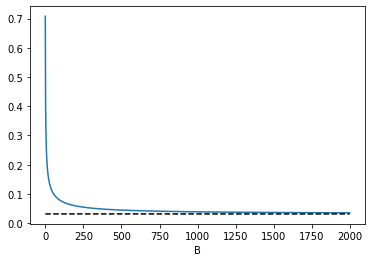

In [30]:
plt.plot(c)
plt.plot(d,'k--')
plt.xlabel('B')

In [31]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [32]:
n = 500
np.random.seed(100)
x = np.float32(np.linspace(0,10,n))
error = np.random.standard_t(2,n)
y = 3*np.cos(x)-5*np.power((x/15),2)+error
y=np.float32(y)
yori = 3*np.cos(x)-5*np.power((x/15),2)

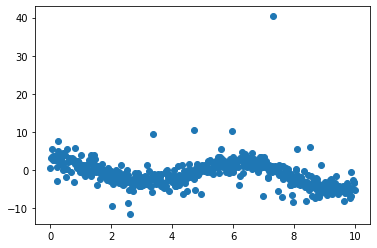

In [33]:
plt.scatter(x,y)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [35]:
X = x.reshape(-1,1)
Y = y.reshape(-1,1)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [36]:
X = torch.FloatTensor(X).to(device)
Y = torch.FloatTensor(Y).to(device)
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [37]:
trainloader = DataLoader(X_train)
testloader = DataLoader(X_test)

In [38]:
class Model(nn.Module):
  '''
  one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules: 
  (i) number of hidden layers equals one; and 
  (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.
  '''
  def __init__(self, in_features=1, h1=10, h2=10, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)    # input layer
    self.fc2 = nn.Linear(h1, h2)            # hidden layer
    self.out = nn.Linear(h2, out_features)  # output layer
        
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

  def training_step(self, x, y):
    pass

  def validation_step(self, x, y):
    pass
  
  def validation_epoch_end(self, outputs):
    pass
  
  def epoch_end(self, epoch, result):
    pass

In [39]:

class ModelTrainer():
  def fit(self, epochs=500, learning_rate=0.01, model=Model(),X_train=X_train,y_train=y_train,criterion = nn.MSELoss(), opt_func=torch.optim.Adam,seed=torch.manual_seed(4)):
    optimizer = opt_func(model.parameters(), learning_rate)

    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss

  def _evaluate(self, model, X_test, y_test,criterion = nn.MSELoss()):
    with torch.no_grad():
      y_val = model.forward(X_test)
      loss = criterion(y_val, y_test)
    return [loss,y_val]



In [40]:
model = Model(h1=8,h2=29).to(device)
model_trainer = ModelTrainer()
model_trainer.fit(500,0.01,model, X_train, y_train)
y_val = model_trainer._evaluate(model,X,Y)[1]

In [41]:
np.random.seed(100)
x = np.float32(np.linspace(0,10,n))
error = np.random.standard_t(2,n)
yori = 3*np.cos(x)-5*np.power((x/15),2)
y = 3*np.cos(x)-5*np.power((x/15),2)+error
y=np.float32(y)

In [42]:
x0 = x.reshape(-1,1)
x = x.reshape(-1,1)
y0 = y.reshape(-1,1)
y = y.reshape(-1,1)
dat = np.concatenate([x,y],axis=1)
x0 = torch.FloatTensor(x0).to(device)
y0 = torch.FloatTensor(y0).to(device)

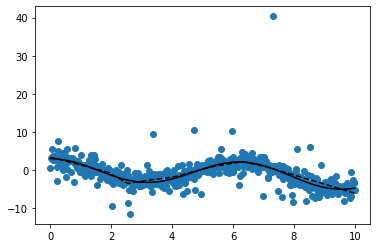

In [43]:
plt.scatter(x0.to('cpu'),y0.to('cpu'))
plt.plot(x0.to('cpu'),yori,'k-')
plt.plot(x0.to('cpu'),y_val.to('cpu'),'k--')
#plt.ylim([-10,10])


In [44]:
a=y_val.cpu().detach().numpy().transpose()
b=x0.cpu().detach().numpy().transpose()
c=y0.cpu().detach().numpy().transpose()

In [45]:
data = np.concatenate((b,c,a),axis=0).transpose()
###first col is x, second col is y, third col is y_hat

In [46]:
data = pd.DataFrame(data)

In [47]:
data = data.rename(columns={0: "x", 1: "y", 2:"y_hat"})

In [21]:
def find_MAD(r,data,i):
  c = abs(data['x']-data['x'][i])<r ##find the neighbour of x 
  mad = np.median(abs(data[c]['y']-data['y_hat'][i])) ## find MAD for those y's in the neighborhood of yhat belongs to x max|y1j-yhat1| j is the true y around yhat1 in x axis
  sigma = mad*1.5/np.sqrt(np.sum(c))
  return sigma

In [22]:
window_size, coverage_rate = [], []
for j in range(1,100):
  sigma=[]
  for i in range(n):
    sigma.append(find_MAD(j/100,data,i))
  upper = a+np.multiply(sigma,1.96)
  lower = a-np.multiply(sigma,1.96)
  coverage_rate.append(np.sum(np.logical_and(yori<upper[0], yori>lower[0]))/n)
  window_size.append(j/100)

In [23]:
count=[]
for r in range(1,100):
  count.append(np.sum(abs(data['x']-data['x'][200])<(r/100)))

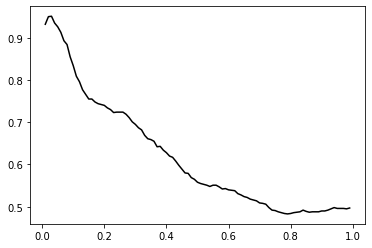

In [24]:
plt.plot(window_size,coverage_rate,'k-')
#plt.ylim([0.8,1])

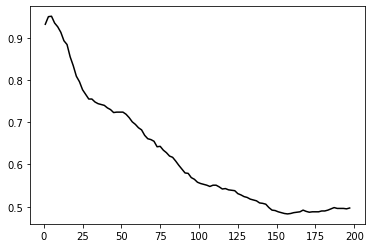

In [25]:
plt.plot(count,coverage_rate,'k-')
#plt.xlim([0,20])

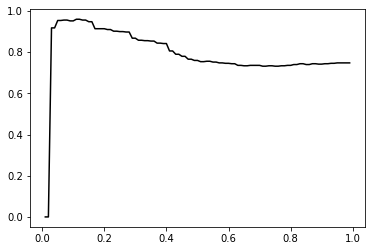

In [48]:
def find_sigma(r,data,i):
  c = abs(data['x']-data['x'][i])<r ##find the neighbour of x 
  sigma = np.std(data[c]['y'])/np.sqrt(np.sum(c)) ## find sigma using the neighbour of x
  return sigma
window_size, coverage_rate = [], []
for j in range(1,100):
  sigma=[]
  for i in range(n):
    sigma.append(find_sigma(j/100,data,i))
  upper = a+np.multiply(sigma,1.96)
  lower = a-np.multiply(sigma,1.96)
  coverage_rate.append(np.sum(np.logical_and(yori<upper[0], yori>lower[0]))/n)
  window_size.append(j/100)


In [ ]:
sigma=[]
for i in range(500):
  sigma.append(find_sigma(0.05,data,i))
upper = a+np.multiply(sigma,1.96)
lower = a-np.multiply(sigma,1.96)
plt.scatter(b,c)
plt.plot(b.reshape(500,1),yori,'k-')
plt.plot(b.reshape(500,1),upper.reshape(500,1),'k--')
plt.plot(b.reshape(500,1),lower.reshape(500,1),'k--')
(np.sum(np.logical_and(yori<upper[0], yori>lower[0]))/n)

In [ ]:
plt.plot(window_size,coverage_rate,'k-')
plt.ylim([0.8,1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


In [ ]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_
{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

In [ ]:
y_val = rf_random.best_estimator_.predict(x)

In [ ]:
plt.scatter(x0.to('cpu'),y0.to('cpu'))
plt.plot(x0.to('cpu'),yori,'k-')
plt.plot(x0.to('cpu'),y_val,'k--')
plt.ylim([-10,10])

In [ ]:
window_size, coverage_rate = [], []
for j in range(1,100):
  sigma=[]
  for i in range(500):
    sigma.append(find_MAD(j/100,data,i))
  upper = y_val+np.multiply(sigma,1.96)
  lower = y_val-np.multiply(sigma,1.96)
  coverage_rate.append(np.sum(np.logical_and(yori<upper[0], yori>lower[0]))/500)
  window_size.append(j/100)

In [ ]:
plt.plot(window_size,coverage_rate,'k-')

In [ ]:
plt.boxplot(sigma)

In [ ]:
upper = a+np.multiply(sigma,1.96)
lower = a-np.multiply(sigma,1.96)

In [ ]:
plt.scatter(b,c)
plt.plot(b.reshape(500,1),yori,'k-')
plt.plot(b.reshape(500,1),upper.reshape(500,1),'k--')
plt.plot(b.reshape(500,1),lower.reshape(500,1),'k--')


In [ ]:
plt.scatter(b,c)
plt.plot(b.reshape(500,1),yori,'k-')
plt.plot(b.reshape(500,1),upper.reshape(500,1),'k--')
plt.plot(b.reshape(500,1),lower.reshape(500,1),'k--')
plt.ylim(-10,10)

In [ ]:
np.sum(np.logical_and(yori<upper[0], yori>lower[0]))